In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from typing import Tuple

import pickle as pkl
import os

from surprise import SVDpp, Dataset, Reader, Trainset
from sklearn.model_selection import train_test_split as skl_train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report

In [2]:
# aisles = pd.read_csv('../instacart/aisles.csv')
# departments = pd.read_csv('../instacart/departments.csv')
# # orderproducts_prior = pd.read_csv('../instacart/order_products__prior.csv')
# orderproducts = pd.read_csv('../instacart/order_products__train.csv')
# orders = pd.read_csv('../instacart/orders.csv')
# products = pd.read_csv('../instacart/products.csv')

In [3]:
# # EDA & Data Preprocessing
# # orderproducts = pd.concat([orderproducts_prior, orderproducts_tests], axis=0)
# userproducts = orderproducts.merge(orders, on='order_id', how='inner')

In [4]:
def prepare_csv_dataset():
    print('(Data Cleaning 0/5) Reading and merging csv dataset ...')
    orderproducts = pd.read_csv('../instacart/order_products__train.csv')
    orders = pd.read_csv('../instacart/orders.csv')

    print('(Data Cleaning 1/5) Filter to only include orders which is in train and test set...')
    orders = orders[orders['eval_set'].isin(['train'])]

    print('(Data Cleaning 2/5) Merge orderproducts and orders, then remove irrelevant columns...')
    userproducts = orderproducts.merge(orders, on='order_id', how='inner')
    userproducts = userproducts[['product_id','user_id','reordered']]

    print('(Data Cleaning 3/5) Remove user which only occur once to prevent error during testing...')
    uid_counts = userproducts['user_id'].value_counts()
    valid_uids = uid_counts[uid_counts > 1].index
    userproducts = userproducts[userproducts['user_id'].isin(valid_uids)]

    print('(Data Cleaning 4/5) Remove duplicated data and missing value if exists...')
    userproducts = userproducts.dropna(inplace=False)
    userproducts = userproducts.drop_duplicates(inplace=False)

    print('(Data Cleaning 5/5) Data Cleaning process is done!')
    return userproducts

cleaned_userproducts = prepare_csv_dataset()
cleaned_userproducts

(Data Cleaning 0/5) Reading and merging csv dataset ...
(Data Cleaning 1/5) Filter to only include orders which is in train and test set...
(Data Cleaning 2/5) Merge orderproducts and orders, then remove irrelevant columns...
(Data Cleaning 3/5) Remove user which only occur once to prevent error during testing...
(Data Cleaning 4/5) Remove duplicated data and missing value if exists...
(Data Cleaning 5/5) Data Cleaning process is done!


,product_id,user_id,reordered
0,49302,112108,1
1,11109,112108,1
2,10246,112108,0
3,49683,112108,0
4,43633,112108,1
...,...,...,...
1384612,14233,169679,1
1384613,35548,169679,1
1384614,35951,139822,1
1384615,16953,139822,1


Number of unique users: 124364


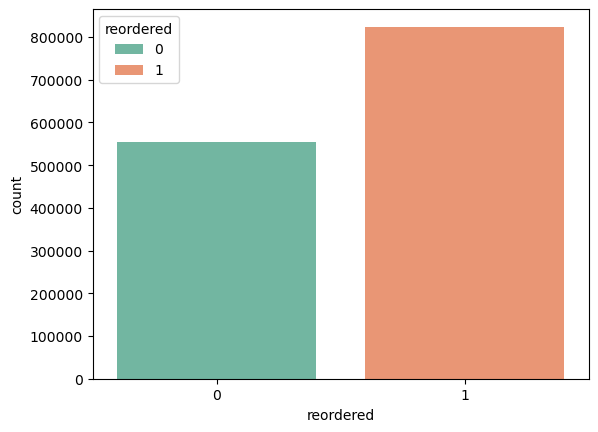

In [5]:
print(f"Number of unique users: {len(cleaned_userproducts['user_id'].unique())}")
sns.countplot(x='reordered', hue='reordered', data=cleaned_userproducts, palette="Set2")
plt.show()

In [6]:
def preprocess_dataset(data, split=True) -> Tuple[Trainset, list | None]:
    userproducts = data.copy()

    if split:
        print('(Data Preprocessing 0/2) Split dataset into train-test 70/30 ratio...')
        train_df, test_df = skl_train_test_split(
            userproducts[['user_id', 'product_id', 'reordered']],
            test_size=0.3,
            random_state=42,
            stratify=userproducts['user_id']
        )

        print('(Data Preprocessing 1/2) Convert dataset into surprise specific dataset...')
        reader = Reader(rating_scale=(0, 1))
        print(len(train_df))
        print(train_df)
        trainset = Dataset.load_from_df(train_df, reader).build_full_trainset()
        testset = list(test_df.itertuples(index=False, name=None))

        print('(Data Preprocessing 2/2) Data Preprocessing process is done!')
        return trainset, testset
    else:
        print('(Data Preprocessing 0/1) Convert dataset into surprise specific dataset...')
        reader = Reader(rating_scale=(0, 1))
        print(len(userproducts))
        print(userproducts)
        trainset = Dataset.load_from_df(userproducts[['user_id','product_id','reordered']], reader).build_full_trainset()

        print('(Data Preprocessing 1/1) Data Preprocessing process is done!')
        return trainset, None

In [7]:
def train_model(trainset : Trainset):
    print('(Model Training 0/1) Model SVDpp training in progress ...')
    model = SVDpp(
        n_factors=20,           n_epochs=20,
        cache_ratings=False,    init_mean=0,
        init_std_dev=0.1,       lr_all=0.007,
        reg_all=0.02,           lr_bu=0.007,
        lr_bi=0.007,            lr_pu=0.007,
        lr_qi=0.007,            lr_yj=0.007,
        reg_bu=0.02,            reg_bi=0.02,
        reg_pu=0.02,            reg_qi=0.02,
        reg_yj=0.02,            random_state=42,
        verbose=True
    )
    model.fit(trainset)
    print('(Model Training 1/1) Model SVDpp training finished ...')
    return model

In [8]:
def classification_approach_test(model : SVDpp, testset : list):
    print('(Classification Approach Test 0/3) Predict estimation value for each testset...')
    predictions = model.test(testset)

    print('(Classification Approach Test 1/3) Round estimation value to 0/1 chosen threshold 0.5')
    y_true = [1 if test[2] > 0 else 0 for test in testset]
    y_pred = [1 if pred.est > 0.5 else 0 for pred in predictions]

    print('(Classification Approach Test 2/3) Calculate precision & recall...')
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

    print('(Classification Approach Test 3/3) This test is done ...')

In [9]:
def top_n_recommendation_test(model : SVDpp, testset : list):
    print('(Top-N Recommendation Test 0/6) Predict estimation value for each testset...')
    predictions = model.test(testset)

    print('(Top-N Recommendation Test 1/6) Compiling user recommendation into dictionary ...')
    user_predictions = defaultdict(list)
    for pred in predictions:
        user_predictions[pred.uid].append(pred)
    
    print('(Top-N Recommendation Test 2/6) Limiting user recommendation to at max n ...')
    top_n_recommendations = {}
    n = 5
    for user, user_preds in user_predictions.items():
        user_preds_sorted = sorted(user_preds, key=lambda x: x.est, reverse=True)
        top_n_recommendations[user] = [pred.iid for pred in user_preds_sorted[:n]]

    print('(Top-N Recommendation Test 3/6) Compiling sets of what the user actually have liked ...')
    user_actual_interactions = defaultdict(set)
    for uid, iid, true_rating in testset:
        if true_rating > 0:
            user_actual_interactions[uid].add(iid)

    print('(Top-N Recommendation Test 4/6) Calculating the accuracy top n-items of each user for each item ...')
    topn_precision = []
    topn_recall = []
    topn_hit_rate = []
    topn_accuracy = []
    for user, recommended_items in sorted(top_n_recommendations.items(), key=lambda x: x[0]):
        actual_interactions = user_actual_interactions.get(user, set())
        if not actual_interactions: continue

        recommended_set = set(recommended_items)
        hits = len(recommended_set.intersection(actual_interactions))

        # debugging purpose
        # print('user', user)
        # print('actual: ', actual_interactions)
        # print('recommended: ', recommended_items)

        # actual calculation
        topn_precision.append(hits / n)
        topn_recall.append(hits / len(actual_interactions))
        topn_hit_rate.append(1 if hits > 0 else 0)

        if len(actual_interactions) <= 0:
            continue
        if len(actual_interactions) < n:
            topn_accuracy.append(hits / len(actual_interactions))
        else:
            topn_accuracy.append(hits / n)

    print('(Top-N Recommendation Test 5/6) Average every result obtained for a user and show result...')
    avg_precision = sum(topn_precision) / len(topn_precision)
    avg_recall = sum(topn_recall) / len(topn_recall)
    hit_rate = sum(topn_hit_rate) / len(topn_hit_rate)
    print(f'Precision@{n}: {avg_precision}')
    print(f'Recall@{n}: {avg_recall}')
    print(f'HitRate@{n}: {hit_rate}')

    avg_topn_accuracy = sum(topn_accuracy) / len(topn_accuracy)
    print(f'Modified Accuracy@{n}: {avg_topn_accuracy}')

    print('(Top-N Recommendation Test 6/6) This test is done...')

In [10]:
def test_model(model : SVDpp, testset : list):
    classification_approach_test(model, testset)
    top_n_recommendation_test(model, testset)

In [11]:
def load_model(state="evaluation"):

    if not (state == "evaluation" or state == "production"):
        print(f"Invalid state...")
        return None, None, None
    
    model_filename = f'../models/svd_model_{state}.pkl'
    trainset_filename = f'../models/svd_trainset_{state}.pkl'
    testset_filename = f'../models/svd_testset_{state}.pkl'

    if os.path.exists(model_filename) and os.path.exists(trainset_filename) and (os.path.exists(testset_filename) or state == "production"):
        print('Model already exist, currently load it ...')
        with open(model_filename,'rb') as f:
            model = pkl.load(f)
        with open(trainset_filename,'rb') as f:
            trainset = pkl.load(f)

        if state == "production": 
            print('Model successfully loaded ...')
            return model, trainset, None
        
        with open(testset_filename,'rb') as f:
            testset = pkl.load(f)
        print('Model successfully loaded ...')
        test_model(model, testset)
        return model, trainset, testset
    else:
        print('Model doesnt exist yet. Train new model ...')
        cleaned_userproducts = prepare_csv_dataset()
        trainset, testset = preprocess_dataset(cleaned_userproducts, split=False if state == "production" else True)
        model = train_model(trainset)

        if state == "evaluation" and testset:
            test_model(model, testset)

        print('Saving trained model ...')
        with open(model_filename,'wb') as f:
            pkl.dump(model, f)
        with open(trainset_filename,'wb') as f:
            pkl.dump(trainset, f)

        if state == "production":
            print('Model successfully saved ...')
            return model, trainset, None
        
        with open(testset_filename,'wb') as f:
            pkl.dump(testset, f)
        print('Model successfully saved ...')
        return model, trainset, testset

In [12]:
model, trainset, testset = load_model(state="evaluation")

Model already exist, currently load it ...
Model successfully loaded ...
(Classification Approach Test 0/3) Predict estimation value for each testset...
(Classification Approach Test 1/3) Round estimation value to 0/1 chosen threshold 0.5
(Classification Approach Test 2/3) Calculate precision & recall...
Precision: 0.7323989616498867
Recall: 0.8256195106966894
[[ 91284  74635]
 [ 43144 204269]]
              precision    recall  f1-score   support

           0       0.68      0.55      0.61    165919
           1       0.73      0.83      0.78    247413

    accuracy                           0.72    413332
   macro avg       0.71      0.69      0.69    413332
weighted avg       0.71      0.72      0.71    413332

(Classification Approach Test 3/3) This test is done ...
(Top-N Recommendation Test 0/6) Predict estimation value for each testset...
(Top-N Recommendation Test 1/6) Compiling user recommendation into dictionary ...
(Top-N Recommendation Test 2/6) Limiting user recommendatio

In [13]:
model, trainset, _ = load_model(state="production")

Model doesnt exist yet. Train new model ...
(Data Cleaning 0/5) Reading and merging csv dataset ...
(Data Cleaning 1/5) Filter to only include orders which is in train and test set...
(Data Cleaning 2/5) Merge orderproducts and orders, then remove irrelevant columns...
(Data Cleaning 3/5) Remove user which only occur once to prevent error during testing...
(Data Cleaning 4/5) Remove duplicated data and missing value if exists...
(Data Cleaning 5/5) Data Cleaning process is done!
(Data Preprocessing 0/1) Convert dataset into surprise specific dataset...
1377772
         product_id  user_id  reordered
0             49302   112108          1
1             11109   112108          1
2             10246   112108          0
3             49683   112108          0
4             43633   112108          1
...             ...      ...        ...
1384612       14233   169679          1
1384613       35548   169679          1
1384614       35951   139822          1
1384615       16953   139822     

In [14]:
model, trainset, testset = load_model(state="eva")

Invalid state...
